# Interval based time series classification in aeon

Interval based approaches look at phase dependant intervals of the full series, calculating summary statistics from selected subseries to be used in classification.

Current interval based approaches are implemented in aeon. Time Series Forest
(TSF) \[1\], the Random Interval Spectral Ensemble (RISE) \[2\], Supervised Time
Series Forest (STSF) \[3\] and Random STSF \[4\], the Canonical Interval Forest (CIF)
\[5\] the Diverse
Representation Canonical Interval Forest (DrCIF) and QUANT \[6\]. Most have the
capability to classify multivariate series.

In this notebook, we will demonstrate how to use these classifiers on the ItalyPowerDemand and BasicMotions datasets.



### Set up

We can list all classifiers of this category like this

In [1]:
import warnings

from sklearn import metrics

from aeon.classification.interval_based import (
    RSTSF,
    CanonicalIntervalForestClassifier,
    DrCIFClassifier,
    QUANTClassifier,
    RandomIntervalSpectralEnsembleClassifier,
    SupervisedTimeSeriesForest,
    TimeSeriesForestClassifier,
)
from aeon.datasets import load_basic_motions, load_italy_power_demand
from aeon.utils.discovery import all_estimators

warnings.filterwarnings("ignore")
all_estimators("classifier", tag_filter={"algorithm_type": "interval"})

[('CanonicalIntervalForestClassifier',
  aeon.classification.interval_based._cif.CanonicalIntervalForestClassifier),
 ('DrCIFClassifier',
  aeon.classification.interval_based._drcif.DrCIFClassifier),
 ('IntervalForestClassifier',
  aeon.classification.interval_based._interval_forest.IntervalForestClassifier),
 ('QUANTClassifier',
  aeon.classification.interval_based._quant.QUANTClassifier),
 ('RSTSF', aeon.classification.interval_based._rstsf.RSTSF),
 ('RandomIntervalClassifier',
  aeon.classification.interval_based._interval_pipelines.RandomIntervalClassifier),
 ('RandomIntervalSpectralEnsembleClassifier',
  aeon.classification.interval_based._rise.RandomIntervalSpectralEnsembleClassifier),
 ('SupervisedIntervalClassifier',
  aeon.classification.interval_based._interval_pipelines.SupervisedIntervalClassifier),
 ('SupervisedTimeSeriesForest',
  aeon.classification.interval_based._stsf.SupervisedTimeSeriesForest),
 ('TimeSeriesForestClassifier',
  aeon.classification.interval_based._tsf

## 2. Load data

In [2]:
X_train, y_train = load_italy_power_demand(split="train")
X_test, y_test = load_italy_power_demand(split="test")
X_test = X_test[:50]
y_test = y_test[:50]

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

X_train_mv, y_train_mv = load_basic_motions(split="train")
X_test_mv, y_test_mv = load_basic_motions(split="test")

X_train_mv = X_train_mv[:50]
y_train_mv = y_train_mv[:50]
X_test_mv = X_test_mv[:50]
y_test_mv = y_test_mv[:50]

print(X_train_mv.shape, y_train_mv.shape, X_test_mv.shape, y_test_mv.shape)

(67, 1, 24) (67,) (50, 1, 24) (50,)
(40, 6, 100) (40,) (40, 6, 100) (40,)


## 3. Time Series Forest (TSF)

TSF is an ensemble of tree classifiers built on the summary statistics of randomly selected intervals.
For each tree ``sqrt(n_timepoints)`` intervals are randomly selected.
From each of these intervals the mean, standard deviation and slope is extracted from each time series and concatenated into a feature vector.
These new features are then used to build a tree, which is added to the ensemble.

In [3]:
tsf = TimeSeriesForestClassifier(n_estimators=50, random_state=47)
tsf.fit(X_train, y_train)

tsf_preds = tsf.predict(X_test)
print("TSF Accuracy: " + str(metrics.accuracy_score(y_test, tsf_preds)))

TSF Accuracy: 0.98


## 4. Random Interval Spectral Ensemble (RISE)

RISE is a tree based interval ensemble aimed at classifying audio data. Unlike TSF, it uses a single interval for each tree, and it uses spectral features rather than summary statistics.

In [4]:
rise = RandomIntervalSpectralEnsembleClassifier(n_estimators=50, random_state=47)
rise.fit(X_train, y_train)

rise_preds = rise.predict(X_test)
print("RISE Accuracy: " + str(metrics.accuracy_score(y_test, rise_preds)))

RISE Accuracy: 0.96


## 5. Supervised Time Series Forest (STSF and RSTSF)

STSF/RSTSF makes a number of adjustments from the original TSF algorithm. A supervised
method of selecting intervals replaces random selection. Features are extracted from intervals generated from additional representations in periodogram and 1st order differences. Median, min, max and interquartile range are included in the summary statistics extracted.

In [6]:
stsf = SupervisedTimeSeriesForest(n_estimators=50, random_state=47)
stsf.fit(X_train, y_train)

stsf_preds = stsf.predict(X_test)
print("STSF Accuracy: " + str(metrics.accuracy_score(y_test, stsf_preds)))

rstsf = RSTSF(n_estimators=20)
rstsf.fit(X_train, y_train)

rstsf_preds = rstsf.predict(X_test)
print("RSTSF Accuracy: " + str(metrics.accuracy_score(y_test, rstsf_preds)))

STSF Accuracy: 1.0
RSTSF Accuracy: 1.0


## 6. Canonical Interval Forest (CIF)

CIF extends from the TSF algorithm. In addition to the 3 summary statistics used by
TSF, CIF makes use of the features from the `Catch22` \[7\] transform.
To increase the diversity of the ensemble, the number of TSF and catch22 attributes is randomly subsampled per tree.

### Univariate

In [7]:
cif = CanonicalIntervalForestClassifier(
    n_estimators=50, att_subsample_size=8, random_state=47
)
cif.fit(X_train, y_train)

cif_preds = cif.predict(X_test)
print("CIF Accuracy: " + str(metrics.accuracy_score(y_test, cif_preds)))

CIF Accuracy: 1.0


### Multivariate



In [8]:
cif_m = CanonicalIntervalForestClassifier(
    n_estimators=50, att_subsample_size=8, random_state=47
)
cif_m.fit(X_train_mv, y_train_mv)

cif_m_preds = cif_m.predict(X_test_mv)
print("CIF Accuracy: " + str(metrics.accuracy_score(y_test_mv, cif_m_preds)))

CIF Accuracy: 1.0


## 6. Diverse Representation Canonical Interval Forest (DrCIF)

DrCIF makes use of the periodogram and differences representations used by STSF as well as the addition summary statistics in CIF.

### Univariate

In [9]:
drcif = DrCIFClassifier(n_estimators=5, att_subsample_size=10, random_state=47)
drcif.fit(X_train, y_train)

drcif_preds = drcif.predict(X_test)
print("DrCIF Accuracy: " + str(metrics.accuracy_score(y_test, drcif_preds)))

DrCIF Accuracy: 0.94


### Multivariate

In [10]:
drcif_m = DrCIFClassifier(n_estimators=5, att_subsample_size=10, random_state=47)
drcif_m.fit(X_train_mv, y_train_mv)

drcif_m_preds = drcif_m.predict(X_test_mv)
print("DrCIF Accuracy: " + str(metrics.accuracy_score(y_test_mv, drcif_m_preds)))

DrCIF Accuracy: 1.0


## 7. QUANT

QUANT is a fast interval based classifier based on quantile features

In [12]:
quant = QUANTClassifier(interval_depth=1)
quant.fit(X_train, y_train)
print("QUANT accuracy =", quant.score(X_test, y_test))

QUANT accuracy = 0.88


## Performance on the UCR univariate datasets

You can find the interval based classifiers as follows.

In [16]:
from aeon.utils.discovery import all_estimators

est = all_estimators("classifier", tag_filter={"algorithm_type": "interval"})
for c in est:
    print(c)

('CanonicalIntervalForestClassifier', <class 'aeon.classification.interval_based._cif.CanonicalIntervalForestClassifier'>)
('DrCIFClassifier', <class 'aeon.classification.interval_based._drcif.DrCIFClassifier'>)
('IntervalForestClassifier', <class 'aeon.classification.interval_based._interval_forest.IntervalForestClassifier'>)
('QUANTClassifier', <class 'aeon.classification.interval_based._quant.QUANTClassifier'>)
('RSTSF', <class 'aeon.classification.interval_based._rstsf.RSTSF'>)
('RandomIntervalClassifier', <class 'aeon.classification.interval_based._interval_pipelines.RandomIntervalClassifier'>)
('RandomIntervalSpectralEnsembleClassifier', <class 'aeon.classification.interval_based._rise.RandomIntervalSpectralEnsembleClassifier'>)
('SupervisedIntervalClassifier', <class 'aeon.classification.interval_based._interval_pipelines.SupervisedIntervalClassifier'>)
('SupervisedTimeSeriesForest', <class 'aeon.classification.interval_based._stsf.SupervisedTimeSeriesForest'>)
('TimeSeriesFores

In [17]:
from aeon.benchmarking.results_loaders import get_estimator_results_as_array
from aeon.datasets.tsc_datasets import univariate

names = [t[0].replace("Classifier", "") for t in est]
names.remove("IntervalForest")  # Base class
names.remove("RandomInterval")  # Pipeline
names.remove("SupervisedInterval")  # Pipeline
results, present_names = get_estimator_results_as_array(
    names, univariate, include_missing=False
)
results.shape

(112, 7)

(<Figure size 600x260 with 1 Axes>, <Axes: >)

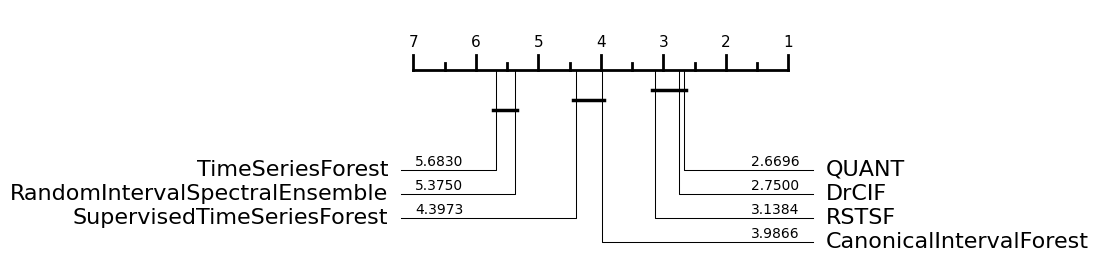

In [18]:
from aeon.visualisation import plot_boxplot, plot_critical_difference

plot_critical_difference(results, names)

(<Figure size 1000x600 with 1 Axes>, <Axes: >)

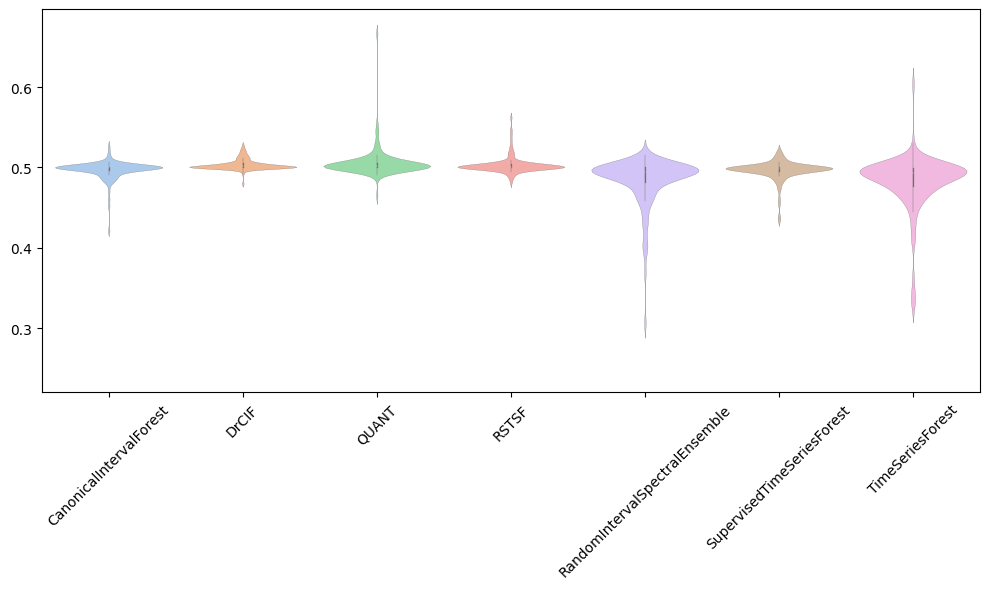

In [19]:
plot_boxplot(results, names, relative=True)

#### References:

\[1\] Deng, H. et al. (2013). A time series forest for classification and feature
extraction. Information Sciences, 239, 142-153.

\[2\] Flynn, M et al. (2019). The contract random interval spectral ensemble (c-RISE):
the effect of contracting a classifier on accuracy. In International Conference on Hybrid Artificial Intelligence Systems (pp. 381-392).

\[3\] Cabello, N. et al. (2020). Fast and Accurate Time Series Classification Through
Supervised Interval Search. In IEEE International Conference on Data Mining.

\[4\] Cabello, N. et al. (2024). Fast, accurate and interpretable time series
classification through randomization.
Data Mining and Knowledge Discovery 38: https://link.springer.com/article/10.1007/s10618-023-00978-w

\[5\] Middlehurst, M. et al. (2020). The Canonical Interval Forest
 (CIF) Classifier for Time Series Classification. IEEE International Conference on Data Mining https://ieeexplore.ieee
 .org/document/9378424
 arXiv version. https://arxiv.org/abs/2008.09172
\[6\] Dempster, A. (2024). QUANT: a minimalist interval method for time series
classification. Data Mining and Knowledge Discovery 38: https://link.springer.com/article/10.1007/s10618-024-01036-9
\[7\] Lubba, C. et al. (2019). catch22: CAnonical Time-series CHaracteristics. Data
Mining and Knowledge Discovery, 33(6), 1821-1852.